# 1. Setup e Carga de Dados - Tech Challenge Fase 3

Este notebook realiza a etapa inicial de **Data Ingestion** e **Data Preparation**.

**Objetivos:**
1. Carregar os datasets (`flights.csv`, `airlines.csv`, `airports.csv`).
2. Realizar o merge (junção) para enriquecer o dataset principal com nomes de companhias e cidades.
3. Criar a variável alvo (`IS_DELAYED`) para futura classificação.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração para exibir todas as colunas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Carga dos Dados

In [2]:
print("Carregando datasets... Isso pode levar alguns segundos devido ao tamanho do flights.csv.")

# Dtypes ajudam a economizar memória durante a carga
flights_dtypes = {
    'YEAR': 'int16',
    'MONTH': 'int8',
    'DAY': 'int8',
    'DAY_OF_WEEK': 'int8',
    'AIRLINE': 'object',
    'FLIGHT_NUMBER': 'int16',
    'TAIL_NUMBER': 'object',
    'ORIGIN_AIRPORT': 'object',
    'DESTINATION_AIRPORT': 'object',
    'DEPARTURE_DELAY': 'float32',
    'ARRIVAL_DELAY': 'float32',
    'DIVERTED': 'int8',
    'CANCELLED': 'int8'
}

try:
    df_flights = pd.read_csv('flights.csv', dtype=flights_dtypes, low_memory=False)
    df_airlines = pd.read_csv('airlines.csv')
    df_airports = pd.read_csv('airports.csv')

    print(f"Flights shape: {df_flights.shape}")
    print(f"Airlines shape: {df_airlines.shape}")
    print(f"Airports shape: {df_airports.shape}")
except FileNotFoundError:
    print("ERRO: Arquivos .csv não encontrados. Verifique se eles estão na mesma pasta deste notebook.")

Carregando datasets... Isso pode levar alguns segundos devido ao tamanho do flights.csv.
Flights shape: (5819079, 31)
Airlines shape: (14, 2)
Airports shape: (322, 7)


## 2. Fusão dos Dados (Merges)

In [3]:
# Visualizando estrutura antes do merge
display(df_flights.head(3))

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.00,-11.00,21.00,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.00,-8.00,12.00,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.00,-2.00,16.00,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# MERGE 1: Adicionar nome da Companhia Aérea
# Chave: flights['AIRLINE'] com airlines['IATA_CODE']
df_merged = df_flights.merge(df_airlines, left_on='AIRLINE', right_on='IATA_CODE', how='left')

# Renomear e limpar
df_merged = df_merged.rename(columns={'AIRLINE_y': 'AIRLINE_NAME', 'AIRLINE_x': 'AIRLINE_CODE'})
df_merged = df_merged.drop('IATA_CODE', axis=1)

# MERGE 2: Adicionar dados do Aeroporto de Origem
# Chave: flights['ORIGIN_AIRPORT'] com airports['IATA_CODE']
# Nota: Existem códigos de aeroporto no flights que são números (IDs) e não batem com o IATA_CODE. 
# O 'how=left' mantém os voos mesmo sem match, mas teremos nulos nas info do aeroporto.
df_merged = df_merged.merge(df_airports, left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', how='left')

df_merged = df_merged.rename(columns={
    'AIRPORT': 'ORIGIN_AIRPORT_NAME',
    'CITY': 'ORIGIN_CITY',
    'STATE': 'ORIGIN_STATE',
    'LATITUDE': 'ORIGIN_LATITUDE',
    'LONGITUDE': 'ORIGIN_LONGITUDE'
})
df_merged = df_merged.drop(['IATA_CODE', 'COUNTRY'], axis=1)

# MERGE 3: Adicionar dados do Aeroporto de Destino
df_merged = df_merged.merge(df_airports, left_on='DESTINATION_AIRPORT', right_on='IATA_CODE', how='left', suffixes=('', '_DEST'))

df_merged = df_merged.rename(columns={
    'AIRPORT': 'DEST_AIRPORT_NAME',
    'CITY': 'DEST_CITY',
    'STATE': 'DEST_STATE',
    'LATITUDE': 'DEST_LATITUDE',
    'LONGITUDE': 'DEST_LONGITUDE'
})
df_merged = df_merged.drop(['IATA_CODE', 'COUNTRY'], axis=1)

print("Shape final após merges:", df_merged.shape)
display(df_merged.head(3))

Shape final após merges: (5819079, 42)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE_NAME,ORIGIN_AIRPORT_NAME,ORIGIN_CITY,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DEST_AIRPORT_NAME,DEST_CITY,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.00,-11.00,21.00,15.00,205.00,194.00,169.00,1448,404.00,4.00,430,408.00,-22.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,Ted Stevens Anchorage International Airport,Anchorage,AK,61.17,-150.00,Seattle-Tacoma International Airport,Seattle,WA,47.45,-122.31
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.00,-8.00,12.00,14.00,280.00,279.00,263.00,2330,737.00,4.00,750,741.00,-9.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,Los Angeles International Airport,Los Angeles,CA,33.94,-118.41,Palm Beach International Airport,West Palm Beach,FL,26.68,-80.10
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.00,-2.00,16.00,34.00,286.00,293.00,266.00,2296,800.00,11.00,806,811.00,5.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,San Francisco International Airport,San Francisco,CA,37.62,-122.37,Charlotte Douglas International Airport,Charlotte,NC,35.21,-80.94


## 3. Definição do Escopo (Target)

Para a modelagem supervisionada, precisamos definir o que é "Atraso".
A FAA (Federal Aviation Administration) considera um voo atrasado se ele chega com mais de **15 minutos** de diferença do horário programado.

Vamos criar a coluna `IS_DELAYED` baseada em `ARRIVAL_DELAY`.

/var/folders/6l/frb0wjw158j5k_dfkfzjzjm80000gn/T/ipykernel_3440/3169425491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['IS_DELAYED'] = np.where(df_clean['ARRIVAL_DELAY'] > 15, 1, 0)


Distribuição da Variável Alvo (IS_DELAYED):
IS_DELAYED
0   0.82
1   0.18
Name: proportion, dtype: float64


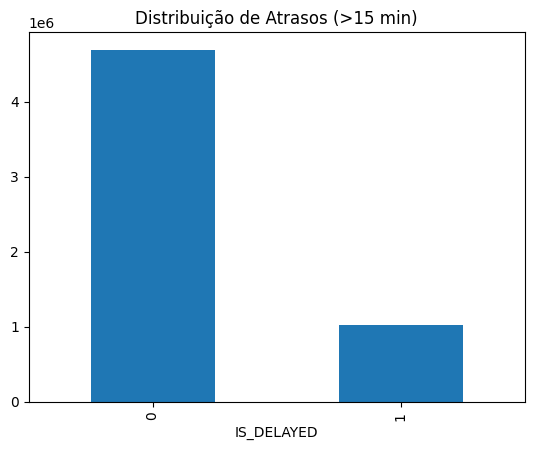

In [5]:
# Tratamento rápido de nulos no atraso (voos cancelados/desviados não têm arrival_delay)
# Vamos focar apenas nos voos que REALMENTE ocorreram para prever atraso
df_clean = df_merged.dropna(subset=['ARRIVAL_DELAY'])

# Criando a classe binária
df_clean['IS_DELAYED'] = np.where(df_clean['ARRIVAL_DELAY'] > 15, 1, 0)

print("Distribuição da Variável Alvo (IS_DELAYED):")
print(df_clean['IS_DELAYED'].value_counts(normalize=True))

df_clean['IS_DELAYED'].value_counts().plot(kind='bar', title='Distribuição de Atrasos (>15 min)')
plt.show()

## 4. Exportação
Salvamos o dataset enriquecido (ou uma amostra dele) para usar nos próximos notebooks (EDA e Modelagem).

In [6]:
# Exportando uma amostra de 100k linhas para desenvolvimento rápido (opcional)
# Para o projeto final, tente usar o dataset todo se a memória permitir
df_sample = df_clean.sample(100000, random_state=42)
df_sample.to_csv('flights_prepared_sample.csv', index=False)
print("Arquivo 'flights_prepared_sample.csv' salvo com sucesso.")

Arquivo 'flights_prepared_sample.csv' salvo com sucesso.
